## make_bry:
### Make lateral boundary conditions, using salt and temp from ECCO2
#### Version id:
#### v1.

In [1]:
run = 'amery_v2km'

import xarray as xr
from netCDF4 import Dataset
import numpy as np 
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime

proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.calc_z import calc_z as calc_z_old
try: 
    from functions import GridStiffness
except:
    print('couldn''t load')

from functions import GridStiffness


# set user parameter and call main routine
grd_file = os.path.join(data_dir,'proc','amery_v2km_v11_grd.nc')
out_file = os.path.join(data_dir,'proc',run+'_Tcline150_bry.nc')

# Path to ECCO2 files for temperature and salinity 1th January 2007
salt_file = os.path.join(data_dir,'raw','ecco2','SALT.nc/')
theta_file = os.path.join(data_dir,'raw','ecco2','THETA.nc/')
uvel_file = os.path.join(data_dir,'raw','ecco2','UVEL.nc/')
vvel_file = os.path.join(data_dir,'raw','ecco2','VVEL.nc/')

# Grid parameters; check grid_file and *.in file to make sure these are correct
N=31
Vtransform=2
Vstretching=4
theta_s=4
theta_b=1
Tcline=150
hc=Tcline # if Vtransform==2, hc=Tcline

# southernmost index of ECCO2 grid to read (1-based)
nbdry_ecco = 300

# upper and lower bounds for temp and salinity
tempUp = 10
tempLow = -3

saltUp = 34.8
saltLow = 33.2

In [2]:
grd = xr.open_dataset(grd_file)
grd.lon_rho.min().values, grd.lon_rho.max().values,grd.lat_rho.min().values, grd.lat_rho.max().values

(array(45.03819717),
 array(89.98263237),
 array(-76.24902385),
 array(-57.51378591))

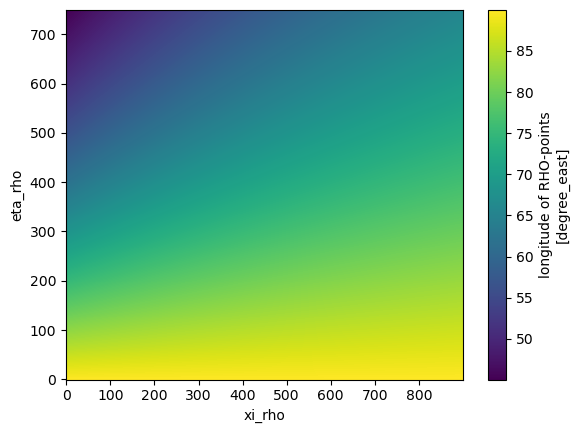

In [3]:
(grd.lon_rho).plot()

In [4]:
# make the interpolation surfaces for the input grid. First use the old style indexing method
z_rho_3d, sc_r, Cs_r = calc_z_old(grd.h, grd.zice, theta_s, theta_b, hc, N)
lon_rho_3d = np.tile(grd.lon_rho, (N,1,1))
lat_rho_3d = np.tile(grd.lat_rho, (N,1,1))

# join together L,T,R,B
# don't flip the R,B faces as ROMS expects to reads from the i/j=1 position outwards.
DepthsInterpSurface = np.concatenate((z_rho_3d[:,:,0],z_rho_3d[:,-1,:],z_rho_3d[:,:,-1],z_rho_3d[:,0,:]),axis=1)
LatInterpSurface = np.concatenate((lat_rho_3d[:,:,0],lat_rho_3d[:,-1,:],lat_rho_3d[:,:,-1],lat_rho_3d[:,0,:]),axis=1)
LonInterpSurface = np.concatenate((lon_rho_3d[:,:,0],lon_rho_3d[:,-1,:],lon_rho_3d[:,:,-1],lon_rho_3d[:,0,:]),axis=1) 

In [5]:
if LonInterpSurface.min() < 0:
    print('WARNING: VALUES BELOW 0, need to wrap longitude around by +360')

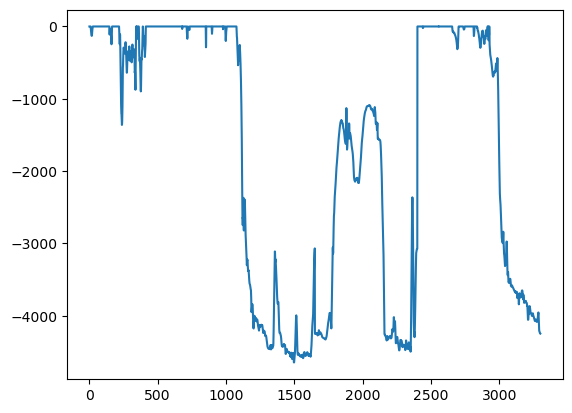

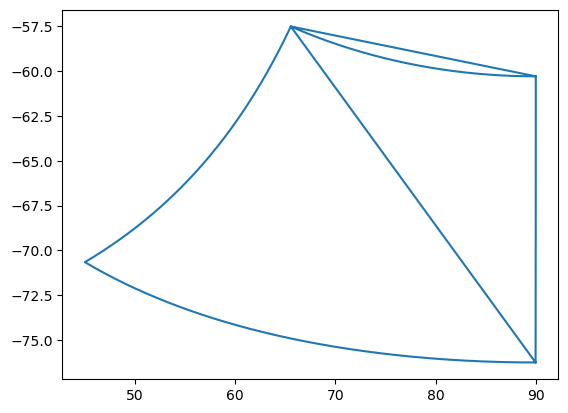

In [6]:
plt.plot(DepthsInterpSurface[0,:])
plt.show()
plt.plot(LonInterpSurface[0,:],LatInterpSurface[0,:])


In [7]:
theta_file+'THETA.1440x720x50.2007*.nc'

'/home/woden/Documents/amery-hires-setup/data/raw/ecco2/THETA.nc/THETA.1440x720x50.2007*.nc'

In [8]:
29982/60/60

8.328333333333333

In [9]:
# Load ECCO2 data

salt_full = xr.open_mfdataset(salt_file+'SALT.1440x720x50.2007*.nc',decode_times=False)
theta_full = xr.open_mfdataset(theta_file+'THETA.1440x720x50.2007*.nc',decode_times=False)
uvel_full = xr.open_mfdataset(uvel_file+'UVEL.1440x720x50.2007*.nc',decode_times=False)
vvel_full = xr.open_mfdataset(vvel_file+'VVEL.1440x720x50.2007*.nc',decode_times=False)


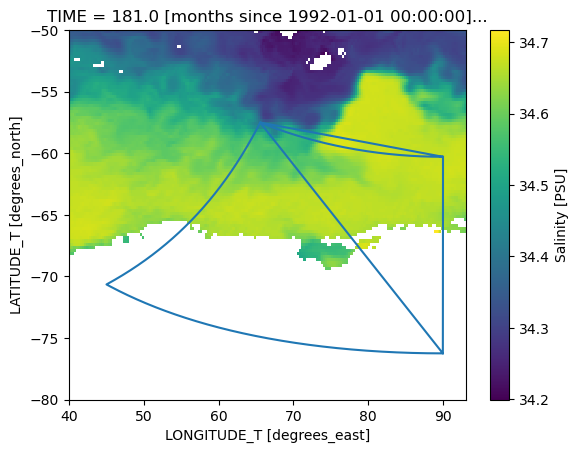

In [10]:
# subset

salt = salt_full.sel(LATITUDE_T=slice(-80,-50),LONGITUDE_T=slice(40,93))
theta = theta_full.sel(LATITUDE_T=slice(-80,-50),LONGITUDE_T=slice(40,93))
uvel = uvel_full.sel(LATITUDE_T=slice(-80,-50),LONGITUDE_T=slice(40,93))
vvel = vvel_full.sel(LATITUDE_T=slice(-80,-50),LONGITUDE_T=slice(40,93))
salt.SALT.isel(TIME=0,DEPTH_T=20).plot()
plt.plot(LonInterpSurface[0,:],LatInterpSurface[0,:])

In [11]:
# define inpaint_nans

def inpaint_nans(inField):
    im = inField.copy()
    import scipy
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = scipy.signal.convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = scipy.signal.convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im

In [12]:
# make array in preparation, with time length

salt_i = np.full((*salt_full.TIME.shape,*LonInterpSurface.shape),np.NaN)
theta_i = np.full((*theta_full.TIME.shape,*LonInterpSurface.shape),np.NaN)
uvel_i = np.full((*uvel_full.TIME.shape,*LonInterpSurface.shape),np.NaN)
vvel_i = np.full((*vvel_full.TIME.shape,*LonInterpSurface.shape),np.NaN)

# start time loop and interpolate values to new locations
from scipy.interpolate import RegularGridInterpolator
for tt in range(len(salt_full.TIME)):
    print('processing time value: ',tt)
    # make the interpolator for each time point
    interp_function_salt = RegularGridInterpolator((salt.LONGITUDE_T.values, salt.LATITUDE_T.values, salt.DEPTH_T.values ), np.transpose(salt.SALT.isel(TIME=tt).values,(2,1,0)), method='linear', bounds_error=False, fill_value=np.NaN)
    interp_function_theta = RegularGridInterpolator((theta.LONGITUDE_T.values, theta.LATITUDE_T.values, theta.DEPTH_T.values ), np.transpose(theta.THETA.isel(TIME=tt).values,(2,1,0)), method='linear', bounds_error=False, fill_value=np.NaN)
    interp_function_uvel = RegularGridInterpolator((salt.LONGITUDE_T.values, salt.LATITUDE_T.values, salt.DEPTH_T.values ), np.transpose(uvel.UVEL.isel(TIME=tt).values,(2,1,0)), method='linear', bounds_error=False, fill_value=np.NaN)
    interp_function_vvel = RegularGridInterpolator((theta.LONGITUDE_T.values, theta.LATITUDE_T.values, theta.DEPTH_T.values ), np.transpose(vvel.VVEL.isel(TIME=tt).values,(2,1,0)), method='linear', bounds_error=False, fill_value=np.NaN)

    # interpolate
    salt_i[tt,:,:] = interp_function_salt((LonInterpSurface, LatInterpSurface, -DepthsInterpSurface))
    theta_i[tt,:,:] = interp_function_theta((LonInterpSurface, LatInterpSurface, -DepthsInterpSurface))
    uvel_i[tt,:,:] = interp_function_uvel((LonInterpSurface, LatInterpSurface, -DepthsInterpSurface))
    vvel_i[tt,:,:] = interp_function_vvel((LonInterpSurface, LatInterpSurface, -DepthsInterpSurface))
    
    
    salt_i[tt,:,:] = inpaint_nans(salt_i[tt,:,:])
    theta_i[tt,:,:] = inpaint_nans(theta_i[tt,:,:])
    uvel_i[tt,:,:] = inpaint_nans(uvel_i[tt,:,:])
    vvel_i[tt,:,:] = inpaint_nans(vvel_i[tt,:,:])    
    

processing time value:  0
processing time value:  1
processing time value:  2
processing time value:  3
processing time value:  4
processing time value:  5
processing time value:  6
processing time value:  7
processing time value:  8
processing time value:  9
processing time value:  10
processing time value:  11


In [13]:
# make the zeta variable. For now set it to zeros
zeta_i = np.zeros_like(salt_i[:,0,:])


In [14]:
# separate out theta, salt, uvvel, vvel 

# left or "WEST"
# SET TO 0 FOR NOW - TO UPDATE IN TIME.
select=slice(0,z_rho_3d.shape[1])
salt_west = salt_i[:,:,select]
temp_west = theta_i[:,:,select]
u_west = uvel_i[:,:,select]
v_west = vvel_i[:,:,select]
# ubar_west = np.zeros(uvel_i[:,:,select].shape)
# vbar_west = np.zeros(vvel_i[:,:,select].shape)
zeta_west = zeta_i[:,select]

# top or "NORTH"
select=slice(z_rho_3d.shape[1],z_rho_3d.shape[1]+z_rho_3d.shape[2])
salt_north = salt_i[:,:,select]
temp_north = theta_i[:,:,select]
u_north = uvel_i[:,:,select]
v_north = vvel_i[:,:,select]
# ubar_north = np.zeros(uvel_i[:,:,select].shape)
# vbar_north = np.zeros(vvel_i[:,:,select].shape)
zeta_north = zeta_i[:,select]

# right or "EAST"
select=slice(z_rho_3d.shape[1]+z_rho_3d.shape[2],z_rho_3d.shape[1]+z_rho_3d.shape[2]+z_rho_3d.shape[1])
temp_east = theta_i[:,:,select]
salt_east = salt_i[:,:,select]
u_east = uvel_i[:,:,select]
v_east = vvel_i[:,:,select]
# ubar_east = np.zeros(uvel_i[:,:,select].shape)
# vbar_east = np.zeros(vvel_i[:,:,select].shape)
zeta_east = zeta_i[:,select]

# bottom or "SOUTH"
select=slice(z_rho_3d.shape[1]+z_rho_3d.shape[2]+z_rho_3d.shape[1],z_rho_3d.shape[1]+z_rho_3d.shape[2]+z_rho_3d.shape[1]+z_rho_3d.shape[2])
temp_south = theta_i[:,:,select]
salt_south = salt_i[:,:,select]
u_south = uvel_i[:,:,select]
v_south = vvel_i[:,:,select]
# ubar_south = np.zeros(uvel_i[:,:,select].shape)
# vbar_south = np.zeros(vvel_i[:,:,select].shape)
zeta_south = zeta_i[:,select]



In [15]:
# Now rotate angles!
angle3 = np.tile(grd.angle, (len(salt_full.TIME), N,1,1))

angle_south = angle3[:,:,0,:]
u_south_unrot = u_south.copy()
v_south_unrot = v_south.copy()
u_south_latlon =  u_south.copy()
v_south_latlon =  v_south.copy()
uv_south = (u_south_latlon + 1j*v_south_latlon) * np.exp(-1j*angle_south)
u_south_rho = uv_south.real
v_south = uv_south.imag
u_south = 0.5 * (u_south_rho[:,:,0:-1]+u_south_rho[:,:,1:])

angle_east = angle3[:,:,:,-1]
u_east_unrot = u_east.copy()
v_east_unrot = v_east.copy()
u_east_latlon =  u_east.copy()
v_east_latlon =  v_east.copy()
uv_east = (u_east_latlon + 1j*v_east_latlon) * np.exp(-1j*angle_east)
u_east = uv_east.real
v_east_rho = uv_east.imag
v_east = 0.5 * (v_east_rho[:,:,0:-1]+v_east_rho[:,:,1:])

angle_north = angle3[:,:,-1,:]
u_north_unrot = u_north.copy()
v_north_unrot = v_north.copy()
u_north_latlon =  u_north.copy()
v_north_latlon =  v_north.copy()
uv_north = (u_north_latlon + 1j*v_north_latlon) * np.exp(-1j*angle_north)
u_north_rho = uv_north.real
v_north = uv_north.imag
u_north = 0.5 * (u_north_rho[:,:,0:-1]+u_north_rho[:,:,1:])

angle_west = angle3[:,:,:,0]
u_west_unrot = u_west.copy()
v_west_unrot = v_west.copy()
u_west_latlon =  u_west.copy()
v_west_latlon =  v_west.copy()
uv_west = (u_west_latlon + 1j*v_west_latlon) * np.exp(-1j*angle_west)
u_west = uv_west.real
v_west_rho = uv_west.imag
v_west = 0.5 * (v_west_rho[:,:,0:-1]+v_west_rho[:,:,1:])


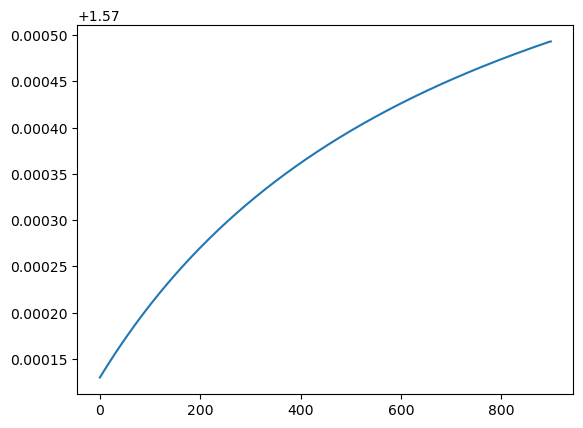

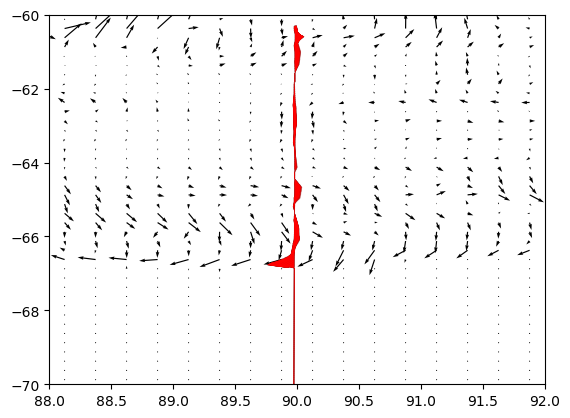

array([89.961829  , 89.96187979, 89.96193045, 89.96198097, 89.96203136,
       89.96208162, 89.96213175, 89.96218174, 89.9622316 , 89.96228133,
       89.96233093, 89.96238039, 89.96242973, 89.96247894, 89.96252802,
       89.96257697, 89.9626258 , 89.96267449, 89.96272306, 89.96277151,
       89.96281983, 89.96286802, 89.96291609, 89.96296403, 89.96301185,
       89.96305955, 89.96310712, 89.96315457, 89.9632019 , 89.96324911,
       89.9632962 , 89.96334316, 89.96339001, 89.96343674, 89.96348335,
       89.96352984, 89.96357621, 89.96362246, 89.9636686 , 89.96371462,
       89.96376052, 89.9638063 , 89.96385198, 89.96389753, 89.96394297,
       89.9639883 , 89.96403351, 89.96407861, 89.9641236 , 89.96416847,
       89.96421324, 89.96425789, 89.96430243, 89.96434686, 89.96439117,
       89.96443538, 89.96447948, 89.96452347, 89.96456735, 89.96461112,
       89.96465479, 89.96469834, 89.96474179, 89.96478513, 89.96482837,
       89.9648715 , 89.96491452, 89.96495744, 89.96500026, 89.96

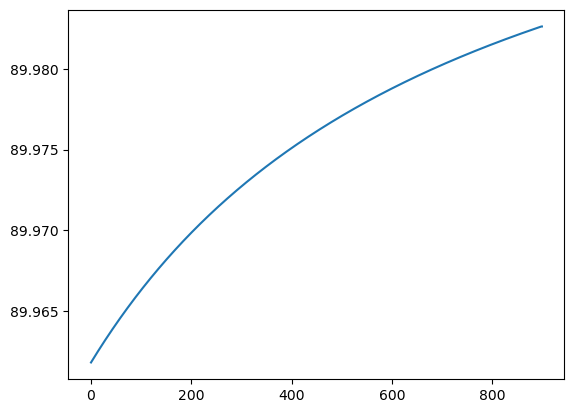

In [16]:
#Check southern boundary
plt.plot(angle_south[0,0,:])
plt.show()
plt.quiver(uvel.LONGITUDE_T,theta.LATITUDE_T,uvel.UVEL.isel(TIME=0,DEPTH_T=5),vvel.VVEL.isel(TIME=0,DEPTH_T=0),scale=2.5)
plt.axis((88,92,-70,-60))
plt.quiver(grd.lon_rho[0,:],grd.lat_rho[0,:],u_south_unrot[0,30,:],v_south_unrot[0,30,:],scale=2.5)
plt.quiver(grd.lon_rho[0,:],grd.lat_rho[0,:],-v_south[0,30,:],u_south_rho[0,30,:],color='r',scale=2.5)
plt.show()
plt.plot(np.rad2deg(grd.angle[0,:]))
np.rad2deg(angle_south[0,0,:])

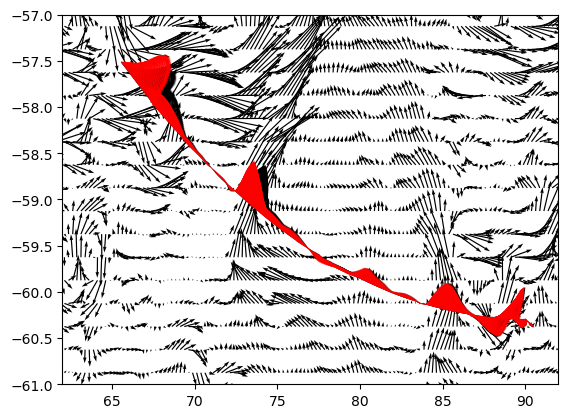

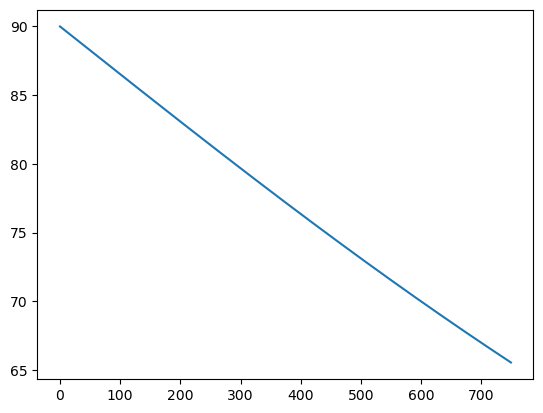

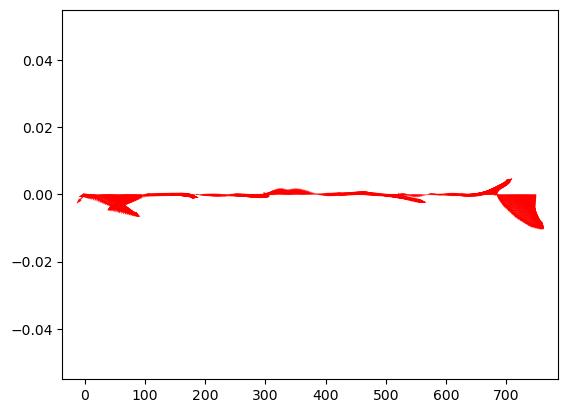

In [17]:
#Check east boundary
                                                                                        
plt.quiver(uvel.LONGITUDE_T,theta.LATITUDE_T,uvel.UVEL.isel(TIME=0,DEPTH_T=5),vvel.VVEL.isel(TIME=0,DEPTH_T=0),scale=2.5)
plt.axis((62,92,-61,-57))
plt.quiver(grd.lon_rho[:,-1],grd.lat_rho[:,-1],u_east_unrot[0,30,:],v_east_unrot[0,30,:],scale=2.5)
plt.quiver(grd.lon_rho[:,-1],grd.lat_rho[:,-1],-v_east_rho[0,30,:],u_east[0,30,:],color='r',scale=2.5)
plt.show()
plt.plot(np.rad2deg(grd.angle[:,-1]))
plt.show()
plt.quiver(u_east[0,30,:],v_east_rho[0,30,:],color='r',scale=2.5)


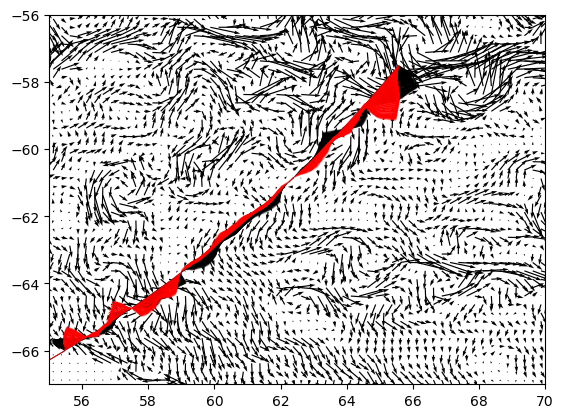

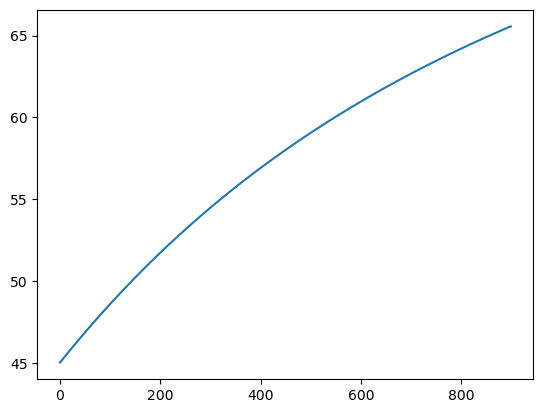

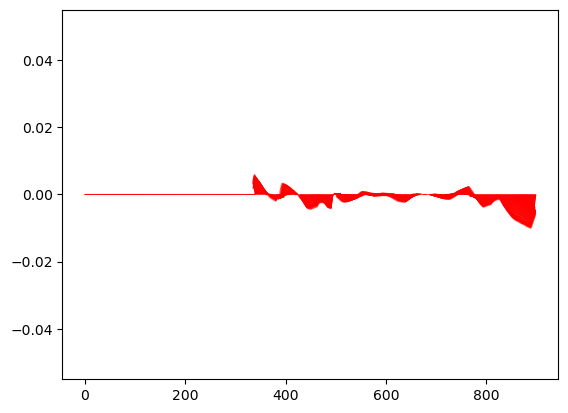

In [18]:
#Check north boundary (remember that north is the model defined north - not my geographic north)
                                                                                        
plt.quiver(uvel.LONGITUDE_T,theta.LATITUDE_T,uvel.UVEL.isel(TIME=0,DEPTH_T=5),vvel.VVEL.isel(TIME=0,DEPTH_T=0),scale=2.5)
plt.axis((55,70,-67,-56))
plt.quiver(grd.lon_rho[-1,:],grd.lat_rho[-1,:],u_north_unrot[0,30,:],v_north_unrot[0,30,:],scale=2.5)
plt.quiver(grd.lon_rho[-1,:],grd.lat_rho[-1,:],u_north_rho[0,30,:],v_north[0,30,:],color='r',scale=2.5)
plt.show()
plt.plot(np.rad2deg(grd.angle[-1,:]))
plt.show()
plt.quiver(u_north_rho[0,30,:],v_north[0,30,:],color='r',scale=2.5)



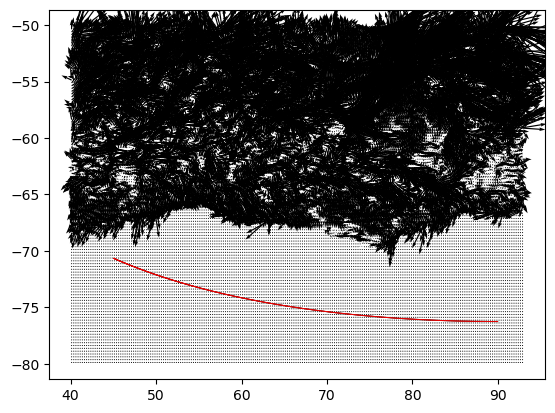

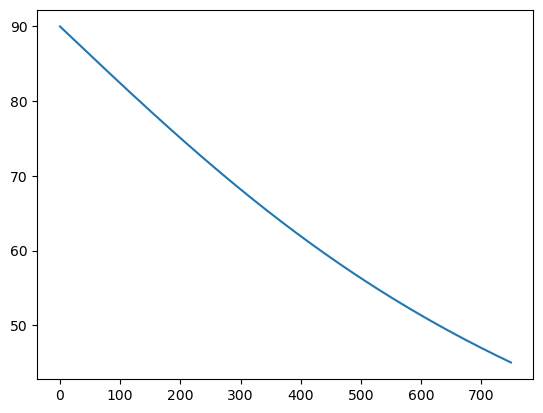

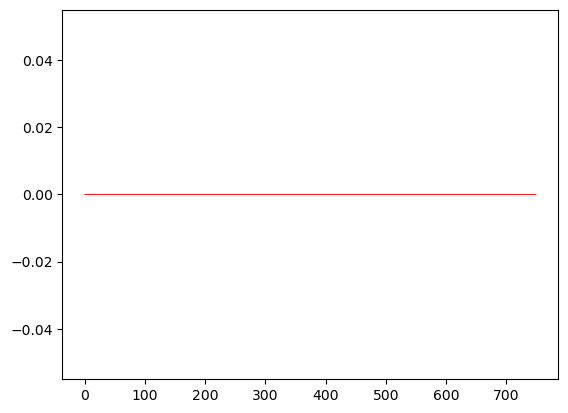

In [19]:
#Check west boundary (remember that west is the model defined north - not my geographic north)
                                                                                        
plt.quiver(uvel.LONGITUDE_T,theta.LATITUDE_T,uvel.UVEL.isel(TIME=0,DEPTH_T=5),vvel.VVEL.isel(TIME=0,DEPTH_T=0),scale=2.5)
# plt.axis((62,92,-61,-57))
plt.quiver(grd.lon_rho[:,0],grd.lat_rho[:,0],u_west_unrot[0,30,:],v_west_unrot[0,30,:],scale=2.5)
plt.quiver(grd.lon_rho[:,0],grd.lat_rho[:,0],u_west[0,30,:],v_west_rho[0,30,:],color='r',scale=2.5)
plt.show()
plt.plot(np.rad2deg(grd.angle[:,0]))
plt.show()
plt.quiver(u_west[0,30,:],v_west_rho[0,30,:],color='r',scale=2.5)


In [20]:
print(u_south.shape)
print(u_east.shape)
print(v_east.shape)

(12, 31, 899)
(12, 31, 750)
(12, 31, 749)


In [21]:
#calculate mapping from u to ubar
z_rho,z_w,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,grd.h,grd.zice) # extract the z_w values

# compute depth average velocity ubar and vbar
# get z at the right position
# based on: https://github.com/ESMG/pyroms/blob/5ea501ef904b01036dd2a0909b7bdc61a56e7eff/examples/Arctic_SODA3.3.1/remap_bdry_uv.py#L309
z_u_north = 0.5 * (z_w[:,-1,:-1] + z_w[:,-1,1:]) # TOP: looks like my _east
z_v_north = 0.5 * (z_w[:,-1,:] + z_w[:,-2,:])
z_u_south = 0.5 * (z_w[:,0,:-1] + z_w[:,0,1:]) # BOTTOM: looks like my _west
z_v_south = 0.5 * (z_w[:,0,:] + z_w[:,1,:])
z_u_east = 0.5 * (z_w[:,:,-1] + z_w[:,:,-2]) # RIGHT: looks like my _north
z_v_east = 0.5 * (z_w[:,:-1,-1] + z_w[:,1:,-1])
z_u_west = 0.5 * (z_w[:,:,0] + z_w[:,:,1]) # LEFT: looks like my _south
z_v_west = 0.5 * (z_w[:,:-1,0] + z_w[:,1:,0])
# based on the averaging, this looks like pyroms expects:
#        _north
# 
# _west         _east
# 
#        _south 

ubar_north = np.zeros(u_north[:,0,:].shape)
ubar_south = np.zeros(u_south[:,0,:].shape)
ubar_east = np.zeros(u_east[:,0,:].shape)
ubar_west = np.zeros(u_west[:,0,:].shape)
vbar_north = np.zeros(v_north[:,0,:].shape)
vbar_south = np.zeros(v_south[:,0,:].shape)
vbar_east = np.zeros(v_east[:,0,:].shape)
vbar_west = np.zeros(v_west[:,0,:].shape)

for tt in range(len(salt_full.TIME)):
    print('processing time value: ',tt)

    for i in range(u_north[tt,:,:].shape[1]):
        ubar_north[tt,i] = (u_north[tt,:,i] * np.diff(z_u_north[:,i])).sum() / -z_u_north[0,i]
        ubar_south[tt,i] = (u_south[tt,:,i] * np.diff(z_u_south[:,i])).sum() / -z_u_south[0,i]
    for i in range(v_north[tt,:,:].shape[1]):
        vbar_north[tt,i] = (v_north[tt,:,i] * np.diff(z_v_north[:,i])).sum() / -z_v_north[0,i]
        vbar_south[tt,i] = (v_south[tt,:,i] * np.diff(z_v_south[:,i])).sum() / -z_v_south[0,i]
    for j in range(u_east[tt,:,:].shape[1]):
        ubar_east[tt,j] = (u_east[tt,:,j] * np.diff(z_u_east[:,j])).sum() / -z_u_east[0,j]
        ubar_west[tt,j] = (u_west[tt,:,j] * np.diff(z_u_west[:,j])).sum() / -z_u_west[0,j]
    for j in range(v_east[tt,:,:].shape[1]):
        vbar_east[tt,j] = (v_east[tt,:,j] * np.diff(z_v_east[:,j])).sum() / -z_v_east[0,j]
        vbar_west[tt,j] = (v_west[tt,:,j] * np.diff(z_v_west[:,j])).sum() / -z_v_west[0,j]


processing time value:  0
processing time value:  1
processing time value:  2
processing time value:  3
processing time value:  4
processing time value:  5
processing time value:  6
processing time value:  7
processing time value:  8
processing time value:  9
processing time value:  10
processing time value:  11


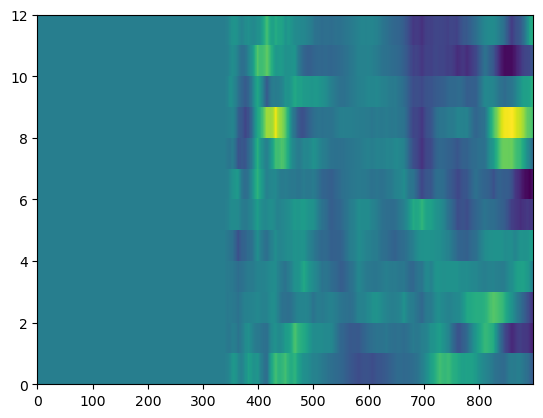

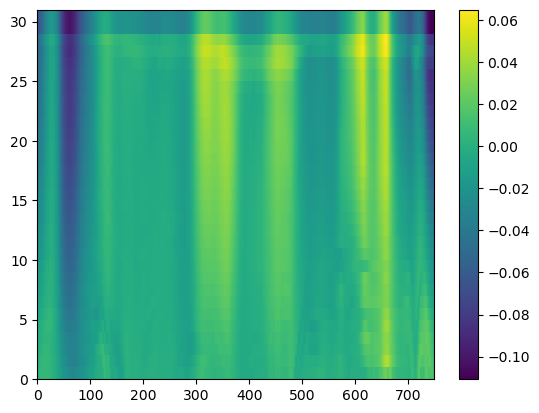

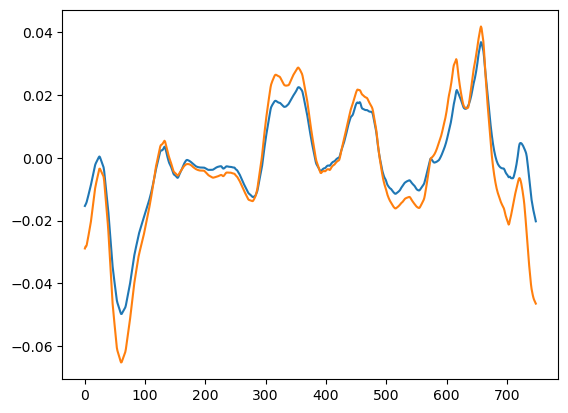

In [22]:
plt.pcolormesh(ubar_north)
plt.show()
plt.pcolormesh(v_east[-1,:,:])
plt.colorbar()
plt.show()
plt.plot(vbar_east[-1,:])
plt.plot(v_east[-1,:,:].mean(axis=0))

In [23]:
z_u_north.shape

(32, 899)

In [24]:
u_north[tt,:,:].shape[1]

899

In [25]:
# settings for making the netcdf file:

time = np.arange(365/12/2,365+365/12/2,365/12) #time values for each data point (units of days)
cycle= 365.0 #days over which to cycle the forcing data

In [26]:
# check for nans and other bad values
variables = ['theta_s','theta_b','Tcline','hc','sc_r','Cs_r','time']



for arr_name in variables:
    arr = locals().get(arr_name)
    if arr is not None:
        if np.isnan(arr).any():
            print(f"Warning: NaN found in array '{arr_name}'")
        # else:
        #     print('no NaN in '+arr_name)
            
#check for nans in all that boundary data

boundary = ['_south','_east','_north','_west']
variables = ['temp','salt','u','v','ubar','vbar']

for bnd in boundary:
    for var in variables:
        arr_name = str(var+bnd)
        arr = locals().get(str(var+bnd))
        if arr is not None:
            if np.isnan(arr).any():
                print(f"Warning: NaN found in array '{arr_name}'")
            # else:
            #     print('no NaN in '+arr_name)

In [27]:
# quick of all field sizes
boundary = ['_south','_east','_north','_west']
variables = ['temp','salt','u','v','ubar','vbar']

for bnd in boundary:
    for var in variables:
        arr_name = str(var+bnd)
        arr = locals().get(str(var+bnd))
        print(f" Size of '{arr_name}' is {arr.shape}")

 Size of 'temp_south' is (12, 31, 900)
 Size of 'salt_south' is (12, 31, 900)
 Size of 'u_south' is (12, 31, 899)
 Size of 'v_south' is (12, 31, 900)
 Size of 'ubar_south' is (12, 899)
 Size of 'vbar_south' is (12, 900)
 Size of 'temp_east' is (12, 31, 750)
 Size of 'salt_east' is (12, 31, 750)
 Size of 'u_east' is (12, 31, 750)
 Size of 'v_east' is (12, 31, 749)
 Size of 'ubar_east' is (12, 750)
 Size of 'vbar_east' is (12, 749)
 Size of 'temp_north' is (12, 31, 900)
 Size of 'salt_north' is (12, 31, 900)
 Size of 'u_north' is (12, 31, 899)
 Size of 'v_north' is (12, 31, 900)
 Size of 'ubar_north' is (12, 899)
 Size of 'vbar_north' is (12, 900)
 Size of 'temp_west' is (12, 31, 750)
 Size of 'salt_west' is (12, 31, 750)
 Size of 'u_west' is (12, 31, 750)
 Size of 'v_west' is (12, 31, 749)
 Size of 'ubar_west' is (12, 750)
 Size of 'vbar_west' is (12, 749)


In [28]:
# misc variables

temp_time=time.copy()
salt_time=time.copy()
v3d_time=time.copy()
v2d_time=time.copy()
zeta_time=time.copy()

theta_s_da = xr.DataArray(theta_s,name='theta_s',attrs={'long_name': 'S-coordinate surface control parameter', 'units': 'nondimensional'} )
theta_b_da = xr.DataArray(theta_s,name='theta_b',attrs={'long_name': 'S-coordinate bottom control parameter', 'units': 'nondimensional'} )
tcline_da = xr.DataArray(Tcline,name='Tcline',attrs={'long_name': 'S-coordinate surface/bottom layer width', 'units': 'meter'} )
hc_da = xr.DataArray(hc,name='hc',attrs={'long_name': 'S-coordinate parameter, critical depth', 'units': 'meter'} )
sc_r_da = xr.DataArray(sc_r,name='sc_r',dims=['s_rho'],attrs={'long_name': 'S-coordinate at RHO-points', 'units': 'nondimensional'} )
cs_r_da = xr.DataArray(Cs_r,name='Cs_r',dims=['s_rho'],attrs={'long_name': 'S-coordinate stretching curves at RHO-points', 'units': 'nondimensional','valid_min':-1.0,'valid_max':0.0} )
temp_time_da = xr.DataArray(temp_time,name='temp_time',dims=['temp_time'],attrs={'long_name': 'time for temperature climatology', 'units': 'day','cycle_length':cycle} )
salt_time_da = xr.DataArray(salt_time,name='salt_time',dims=['salt_time'],attrs={'long_name': 'time for salinity climatology', 'units': 'day','cycle_length':cycle} )
v3d_time_da = xr.DataArray(v3d_time,name='v3d_time',dims=['v3d_time'],attrs={'long_name': 'time for 3d-velocity climatology', 'units': 'day','cycle_length':cycle} )
v2d_time_da = xr.DataArray(v2d_time,name='v2d_time',dims=['v2d_time'],attrs={'long_name': 'time for 2d-velocity climatology', 'units': 'day','cycle_length':cycle} )
zeta_time_da = xr.DataArray(zeta_time,name='zeta_time',dims=['zeta_time'],attrs={'long_name': 'time for ssh climatology', 'units': 'day','cycle_length':cycle} )

# make nth boundary data
temp_north_da = xr.DataArray(temp_north,name='temp_north',dims=['temp_time','s_rho', 'xi_rho'],attrs={'long_name': 'northern boundary potential temperature',
 'standard_name': 'temp_north','units': 'Celsius','_FillValue':'-1e34','missing_value':'-1e34'})
salt_north_da = xr.DataArray(salt_north,name='salt_north',dims=['salt_time','s_rho', 'xi_rho'],attrs={'long_name': 'northern boundary salinity',
 'standard_name': 'temp_north','units': 'PSU','_FillValue':'-1e34','missing_value':'-1e34'})
u_north_da = xr.DataArray(u_north,name='u_north',dims=['v3d_time','s_rho','xi_u'],attrs={'long_name': 'northern boundary u-momentum component',
 'standard_name': 'u_north','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
v_north_da = xr.DataArray(v_north,name='v_north',dims=['v3d_time','s_rho', 'xi_rho'],attrs={'long_name': 'northern boundary v-momentum component',
 'standard_name': 'v_north','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
ubar_north_da = xr.DataArray(ubar_north,name='ubar_north',dims=['v2d_time','xi_u'],attrs={'long_name': 'northern boundary vertically integrated u-momentum component',
 'standard_name': 'ubar_north','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
vbar_north_da = xr.DataArray(vbar_north,name='vbar_north',dims=['v2d_time','xi_rho'],attrs={'long_name': 'northern boundary vertically integrated v-momentum component',
 'standard_name': 'vbar_north','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
zeta_north_da = xr.DataArray(zeta_north,name='zeta_north',dims=['zeta_time','xi_rho'],attrs={'long_name': 'northern boundary sea surface height',
 'standard_name': 'zeta_north','units': 'meter','_FillValue':'-1e34','missing_value':'-1e34'})

# make sth boundary data
temp_south_da = xr.DataArray(temp_south,name='temp_south',dims=['temp_time','s_rho','xi_rho'],attrs={'long_name': 'southern boundary potential temperature',
 'standard_name': 'temp_south','units': 'Celsius','_FillValue':'-1e34','missing_value':'-1e34'})
salt_south_da = xr.DataArray(salt_south,name='salt_south',dims=['salt_time','s_rho','xi_rho'],attrs={'long_name': 'southern boundary salinity',
 'standard_name': 'temp_south','units': 'PSU','_FillValue':'-1e34','missing_value':'-1e34'})
u_south_da = xr.DataArray(u_south,name='u_south',dims=['v3d_time','s_rho','xi_u'],attrs={'long_name': 'southern boundary u-momentum component',
 'standard_name': 'u_south','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
v_south_da = xr.DataArray(v_south,name='v_south',dims=['v3d_time','s_rho', 'xi_rho'],attrs={'long_name': 'southern boundary v-momentum component',
 'standard_name': 'v_south','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
ubar_south_da = xr.DataArray(ubar_south,name='ubar_south',dims=['v2d_time','xi_u'],attrs={'long_name': 'southern boundary vertically integrated u-momentum component',
 'standard_name': 'ubar_south','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
vbar_south_da = xr.DataArray(vbar_south,name='vbar_south',dims=['v2d_time','xi_rho'],attrs={'long_name': 'southern boundary vertically integrated v-momentum component',
 'standard_name': 'vbar_south','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
zeta_south_da = xr.DataArray(zeta_south,name='zeta_south',dims=['zeta_time','xi_rho'],attrs={'long_name': 'southern boundary sea surface height',
 'standard_name': 'zeta_south','units': 'meter','_FillValue':'-1e34','missing_value':'-1e34'})

# make eastern boundary data
temp_east_da = xr.DataArray(temp_east,name='temp_east',dims=['temp_time','s_rho','eta_rho'],attrs={'long_name': 'eastern boundary potential temperature',
 'standard_name': 'temp_east','units': 'Celsius','_FillValue':'-1e34','missing_value':'-1e34'})
salt_east_da = xr.DataArray(salt_east,name='salt_east',dims=['salt_time','s_rho', 'eta_rho'],attrs={'long_name': 'eastern boundary salinity',
 'standard_name': 'temp_east','units': 'PSU','_FillValue':'-1e34','missing_value':'-1e34'})
u_east_da = xr.DataArray(u_east,name='u_east',dims=['v3d_time','s_rho', 'eta_rho'],attrs={'long_name': 'eastern boundary u-momentum component',
 'standard_name': 'u_east','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
v_east_da = xr.DataArray(v_east,name='v_east',dims=['v3d_time','s_rho', 'eta_v'],attrs={'long_name': 'eastern boundary v-momentum component',
 'standard_name': 'v_east','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
ubar_east_da = xr.DataArray(ubar_east,name='ubar_east',dims=['v2d_time','eta_rho'],attrs={'long_name': 'eastern boundary vertically integrated u-momentum component',
 'standard_name': 'ubar_east','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
vbar_east_da = xr.DataArray(vbar_east,name='vbar_east',dims=['v2d_time','eta_v'],attrs={'long_name': 'eastern boundary vertically integrated v-momentum component',
 'standard_name': 'vbar_east','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
zeta_east_da = xr.DataArray(zeta_east,name='zeta_east',dims=['zeta_time','eta_rho'],attrs={'long_name': 'eastern boundary sea surface height',
 'standard_name': 'zeta_east','units': 'meter','_FillValue':'-1e34','missing_value':'-1e34'})

# make western boundary data
temp_west_da = xr.DataArray(temp_west,name='temp_west',dims=['temp_time','s_rho', 'eta_rho'],attrs={'long_name': 'western boundary potential temperature',
 'standard_name': 'temp_west','units': 'Celsius','_FillValue':'-1e34','missing_value':'-1e34'})
salt_west_da = xr.DataArray(salt_west,name='salt_west',dims=['salt_time','s_rho', 'eta_rho'],attrs={'long_name': 'western boundary salinity',
 'standard_name': 'temp_west','units': 'PSU','_FillValue':'-1e34','missing_value':'-1e34'})
u_west_da = xr.DataArray(u_west,name='u_west',dims=['v3d_time','s_rho', 'eta_rho'],attrs={'long_name': 'western boundary u-momentum component',
 'standard_name': 'u_west','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
v_west_da = xr.DataArray(v_west,name='v_west',dims=['v3d_time','s_rho', 'eta_v'],attrs={'long_name': 'western boundary v-momentum component',
 'standard_name': 'v_west','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
ubar_west_da = xr.DataArray(ubar_west,name='ubar_west',dims=['v2d_time','eta_rho'],attrs={'long_name': 'western boundary vertically integrated u-momentum component',
 'standard_name': 'ubar_west','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
vbar_west_da = xr.DataArray(vbar_west,name='vbar_west',dims=[ 'v2d_time','eta_v'],attrs={'long_name': 'western boundary vertically integrated v-momentum component',
 'standard_name': 'vbar_west','units': 'meter second-1','_FillValue':'-1e34','missing_value':'-1e34'})
zeta_west_da = xr.DataArray(zeta_west,name='zeta_west',dims=[ 'zeta_time','eta_rho'],attrs={'long_name': 'western boundary sea surface height',
 'standard_name': 'zeta_west','units': 'meter','_FillValue':'-1e34','missing_value':'-1e34'})

frc = xr.Dataset({'theta_s':theta_s_da,
                'theta_b':theta_b_da,
                'Tcline':tcline_da,
                'hc':hc_da,
                'sc_r':sc_r_da,
                'Cs_r':cs_r_da,
                'temp_time':temp_time_da,
                'salt_time':salt_time_da,
                'v3d_time':v3d_time_da,
                'v2d_time':v2d_time_da,
                'zeta_time':zeta_time_da,
                'temp_north':temp_north_da,
                'salt_north':salt_north_da,
                'u_north':u_north_da,
                'v_north':v_north_da,
                'ubar_north':ubar_north_da,
                'vbar_north':vbar_north_da,
                'zeta_north':zeta_north_da,
                'temp_south':temp_south_da,
                'salt_south':salt_south_da,
                'u_south':u_south_da,
                'v_south':v_south_da,
                'ubar_south':ubar_south_da,
                'vbar_south':vbar_south_da,
                'zeta_south':zeta_south_da,
                'temp_east':temp_east_da,
                'salt_east':salt_east_da,
                'u_east':u_east_da,
                'v_east':v_east_da,
                'ubar_east':ubar_east_da,
                'vbar_east':vbar_east_da,
                'zeta_east':zeta_east_da,              
                'temp_west':temp_west_da,
                'salt_west':salt_west_da,
                'u_west':u_west_da,
                'v_west':v_west_da,
                'ubar_west':ubar_west_da,
                'vbar_west':vbar_west_da,
                'zeta_west':zeta_west_da},
               attrs={'title':'ROMS Lateral Boundaries',
                      'history': 'BOUNDARY file using make_bry.py,'+str(datetime.date.today()),
                      'clim_name':out_file,
                      'grd_file':grd_file,
                      'type': 'BOUNDARY file'})

In [29]:
print('made forcing at ',out_file)
frc.to_netcdf(out_file)

made forcing at  /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_Tcline150_bry.nc
